In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingClassifier

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

plt.style.use('ggplot')

In [3]:
features_target_train = pd.read_csv("data/features_target_train.csv")
features_target_test = pd.read_csv("data/features_target_test.csv")

In [4]:
columns = features_target_train.columns

In [5]:
X_train = features_target_train[columns[:-1]]
X_test = features_target_test[columns[:-1]]

y_train = features_target_train[columns[-1]]
y_test = features_target_test[columns[-1]]

# Check for zero variance columns

In [6]:
col_to_del = []
for column, variance in X_train.var().items():
    if variance == 0:
        print(column, variance)
        col_to_del.append(column)

SMR_VSA8 0.0
SlogP_VSA9 0.0
fr_diazo 0.0
fr_prisulfonamd 0.0


Remove zero variance columns from X_train and X_test

In [7]:
X_train = X_train.drop(columns=col_to_del)
X_test = X_test.drop(columns=col_to_del)

# PCA
I will apply a 95% PCA

In [8]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [9]:
print(f"Number of components: {pca.n_components_}")

Number of components: 87


# Train and test

## Logistic regression

In [10]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train_pca, y_train)

LogisticRegression(class_weight='balanced')

In [11]:
predictions = lr.predict(X_test_pca)
print(f"Accuracy score: {accuracy_score(y_test, predictions) * 100:.2f}%")

Accuracy score: 57.77%


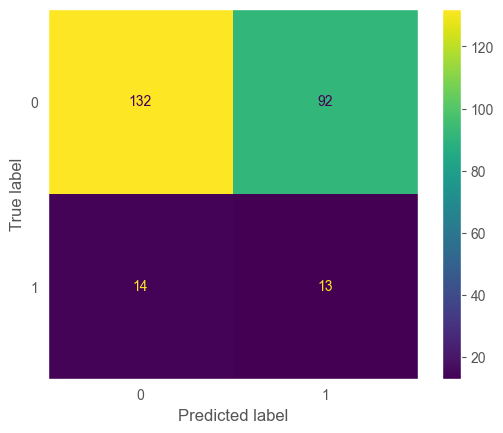

In [12]:
fig, ax = plt.subplots()    

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions))
disp.plot(ax=ax)
ax.grid()
plt.show()

## HistGradientBoostingClassifier

In [13]:
gradient_boosting = HistGradientBoostingClassifier(class_weight="balanced")
gradient_boosting.fit(X_train_pca, y_train)

HistGradientBoostingClassifier(class_weight='balanced')

In [14]:
predictions = gradient_boosting.predict(X_test_pca)
print(f"Accuracy score: {accuracy_score(y_test, predictions) * 100:.2f}%")

Accuracy score: 83.27%


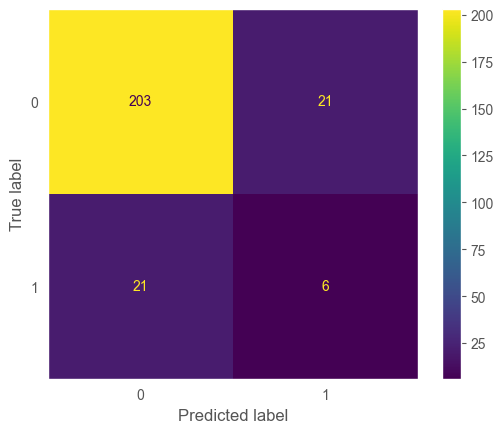

In [15]:
fig, ax = plt.subplots()    

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions))
disp.plot(ax=ax)
ax.grid()
plt.show()

## Shallow neural network

In [16]:
classifier = Sequential()

classifier.add(Dense(200, activation="sigmoid", kernel_initializer="random_normal", input_dim=X_train_pca.shape[1], name="HiddenLayer1"))

#classifier.add(Dense(2*pca.n_components_, activation="sigmoid", kernel_initializer="random_normal", input_dim=pca.n_components_, name="HiddenLayer2"))

#classifier.add(Dense(pca.n_components_, activation="sigmoid", kernel_initializer="random_normal", input_dim=pca.n_components_, name="HiddenLayer3"))

classifier.add(Dense(1, activation="sigmoid", kernel_initializer="random_normal", name="OutputLayer"))

classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["f1_score"])

C:\Users\lucat\anaconda3\envs\MOLECULES\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
print(classifier.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ HiddenLayer1 (Dense)            │ (None, 200)            │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [18]:
COUNT_NON_TOXIC = y_train.value_counts()[0]
COUNT_TOXIC = y_train.value_counts()[1]

initial_bias = np.log([COUNT_TOXIC / COUNT_NON_TOXIC])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_MOLECULE_COUNT = COUNT_TOXIC + COUNT_NON_TOXIC
weight_for_0 = (1 / COUNT_NON_TOXIC) * TRAIN_MOLECULE_COUNT / 2.0
weight_for_1 = (1 / COUNT_TOXIC) * TRAIN_MOLECULE_COUNT / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: -1.95975
Weight for class 0: 0.57
Weight for class 1: 4.05


In [19]:
history = classifier.fit(X_train_pca, y_train,
                         epochs=30,
                         batch_size=16,
                         validation_data=(X_test_pca, y_test),
                         class_weight=class_weight)

Epoch 1/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.2176 - loss: 0.6330 - val_f1_score: 0.1942 - val_loss: 0.7840
Epoch 2/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2222 - loss: 0.5770 - val_f1_score: 0.1942 - val_loss: 0.8409
Epoch 3/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2210 - loss: 0.5640 - val_f1_score: 0.1942 - val_loss: 0.7592
Epoch 4/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2317 - loss: 0.5751 - val_f1_score: 0.1942 - val_loss: 0.8717
Epoch 5/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2133 - loss: 0.5341 - val_f1_score: 0.1942 - val_loss: 0.7972
Epoch 6/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2271 - loss: 0.5477 - val_f1_score: 0.1942 - val_loss: 0.8012
Epoch 7/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2228 - loss: 0.5493 - val_f1_score: 0.1942 - val_loss: 0.6256
Epoch 8/30
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2286 - loss: 0.5535 - val_f1_score: 0.

<Axes: >

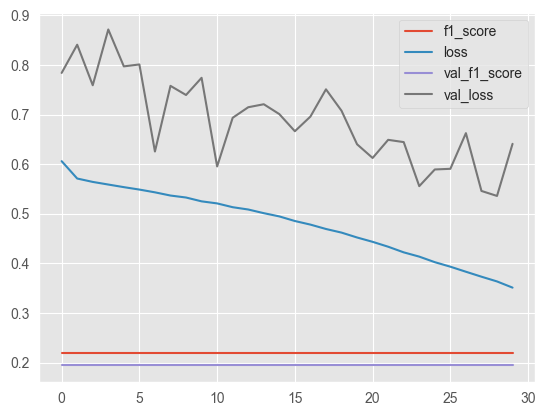

In [20]:
pd.DataFrame(history.history).plot()

In [21]:
def classification_function(x: float):
    if x < 0.5:
        return 0
    else:
        return 1

predictions = np.array([classification_function(x) for x in classifier.predict(X_test_pca)])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [22]:
print(f"Accuracy score: {accuracy_score(y_test, predictions) * 100:.2f}%")

Accuracy score: 72.91%


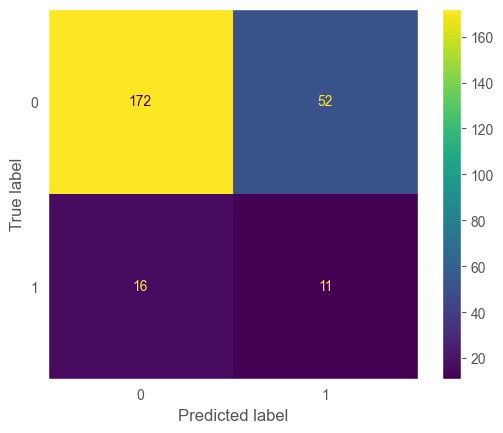

In [23]:
fig, ax = plt.subplots()    

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions))
disp.plot(ax=ax)
ax.grid()
plt.show()

No good